The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

## Importing Packages

In [1]:
import os
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

### Device Agnostic Code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Visualization

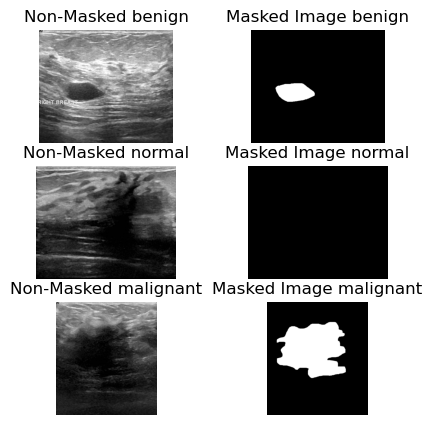

In [3]:
directory = '/kaggle/input'
fig, axes = plt.subplots(3, 2, figsize=(5, 5))
itr = 0
for root, dirs, filenames in os.walk(directory):
    img_c = 0
    for file in filenames:
        #print(img_c)
        if img_c == 0:
            pass
        else:
            #print(temp.split('.')[0]+'_mask.png')
            if temp.split('.')[0]+'_mask' in file:
                file_path = os.path.join(root, file)
                #print(file_path)
                image = Image.open(file_path)
                axes[itr][img_c].imshow(image, cmap='gray')  
                axes[itr][img_c].set_title(f"Masked Image {file.split(' ')[0]}")
                axes[itr][img_c].axis('off')
                itr = itr + 1
                break
        if 'mask' not in file:
            if img_c > 0:
                continue
            temp = file
            file_path = os.path.join(root, file)
            #print(file_path)
            image = Image.open(file_path)
            axes[itr][img_c].imshow(image, cmap='gray')  
            axes[itr][img_c].set_title(f"Non-Masked {file.split(' ')[0]}")
            axes[itr][img_c].axis('off')
            img_c = img_c + 1
            #print(img_c, itr)

## Data Generator

In [4]:
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms


preprocess_X = transforms.Compose([
            transforms.Resize((572, 572)),
            transforms.ToTensor()])

preprocess_y = transforms.Compose([
            transforms.Resize((574, 574)),
            transforms.ToTensor()])

class CustomDataset(Dataset):
    def __init__(self, image_x_list, image_y_list):
        self.image_x_list = image_x_list
        self.image_y_list = image_y_list
    
    def __len__(self):
        return len(self.image_x_list)
    
    def __getitem__(self, index):
        return self.image_x_list[index], self.image_y_list[index]



In [5]:
train_img_X = []
train_img_y = []

for root, dirs, filenames in os.walk(directory):
    for file in filenames:
        if 'mask' not in file:
            file_path = os.path.join(root, file)
            image_X = Image.open(file_path).convert("L")
            print(file)
            size = image_X.size
            image_X = preprocess_X(image_X)
            blank_image_y = Image.new('L', size, 0)
            if 'normal' in file:
                print(file)
                image_y = preprocess_y(blank_image_y)
            else:
                for masked_file in filenames:
                    if file.split('.')[0]+'_' in masked_file:
                        print(masked_file)
                        masked_file_path = os.path.join(root, masked_file)
                        image_to_paste = Image.open(masked_file_path)

                        x_offset = (blank_image_y.width - image_to_paste.width) // 2
                        y_offset = (blank_image_y.height - image_to_paste.height) // 2
                        blank_image_y.paste(image_to_paste, (x_offset, y_offset), image_to_paste)
                        
                image_y = preprocess_y(blank_image_y)
                
            train_img_X.append(image_X)
            train_img_y.append(image_y)

dataset = CustomDataset(train_img_X, train_img_y)

benign (2).png
benign (2)_mask.png
benign (285).png
benign (285)_mask.png
benign (300).png
benign (300)_mask.png
benign (390).png
benign (390)_mask.png
benign (357).png
benign (357)_mask.png
benign (428).png
benign (428)_mask.png
benign (98).png
benign (98)_mask_1.png
benign (98)_mask.png
benign (246).png
benign (246)_mask.png
benign (217).png
benign (217)_mask.png
benign (276).png
benign (276)_mask.png
benign (103).png
benign (103)_mask.png
benign (342).png
benign (342)_mask.png
benign (181).png
benign (181)_mask.png
benign (181)_mask_1.png
benign (71).png
benign (71)_mask.png
benign (50).png
benign (50)_mask.png
benign (265).png
benign (265)_mask.png
benign (6).png
benign (6)_mask.png
benign (160).png
benign (160)_mask.png
benign (147).png
benign (147)_mask.png
benign (308).png
benign (308)_mask.png
benign (294).png
benign (294)_mask.png
benign (304).png
benign (304)_mask.png
benign (404).png
benign (404)_mask.png
benign (108).png
benign (108)_mask.png
benign (284).png
benign (284)_m

### Data Generator features

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size  

train_subset = Subset(dataset, range(train_size))
test_subset = Subset(dataset, range(train_size, len(dataset)))

In [7]:
batch_size = 8
#data_loader = DataLoader(dataset, batch_size=8, shuffle=True)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [8]:
train_X_batch, train_y_batch = next(iter(train_loader))
print(train_X_batch.shape, train_y_batch.shape)
print(f"Length of train dataloader: {len(train_loader)}")

torch.Size([8, 1, 572, 572]) torch.Size([8, 1, 574, 574])
Length of train dataloader: 78


In [9]:
for batch in train_loader:
    image_x_batch, image_y_batch = batch
    break
    
print(image_x_batch.shape)
print(image_y_batch.shape)

torch.Size([8, 1, 572, 572])
torch.Size([8, 1, 574, 574])


1
Image size: torch.Size([1, 572, 572])
Masked image size: torch.Size([1, 574, 574])


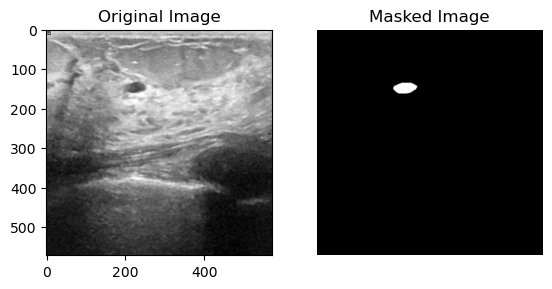

In [10]:
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_X_batch), size=[1]).item()
print(random_idx)
img_X, img_y = train_X_batch[random_idx], train_y_batch[random_idx]

fig,axs = plt.subplots(1, 2)
axs[0].imshow(img_X.squeeze(), cmap="gray")
axs[0].set_title('Original Image')
axs[1].imshow(img_y.squeeze(), cmap="gray")
axs[1].set_title('Masked Image')
plt.axis("Off");
print(f"Image size: {img_X.shape}")
print(f"Masked image size: {img_y.shape}")

## U-Net Architecture

In [11]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.seq_1 = nn.Sequential(
                                nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
                                nn.ReLU())
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.seq_2 = nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
                                nn.ReLU())
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.seq_3 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
                                nn.ReLU())
        self.up_conv_1 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.seq_4 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
                                nn.ReLU())
        self.up_conv_2 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        self.seq_5 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1,padding=1)
                                )
        
    def forward(self,x):
        x1 = self.seq_1(x)
        x2 = self.max_pool_1(x1)
        x3 = self.seq_2(x2)
        x4 = self.max_pool_2(x3)
        x5 = self.seq_3(x4)
        x6 = self.up_conv_1(x5)
        x7 = torch.cat([x3,x6], 1)
        x8 = self.seq_4(x7)
        x9 = self.up_conv_2(x8)
        x10 = torch.cat([x1,x9], 1)
        x11 = self.seq_5(x10)
        return x11, x11.shape

## Defining Loss and Optimizer

In [12]:
model_1 = Unet().to(device)

#device_ids = [0, 1] 

#model_1 = nn.DataParallel(model_1, device_ids=device_ids)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                        lr=0.01)

## Model Training and Forward Propogation

In [13]:
torch.manual_seed(42)

Epochs = 3
for epoch in tqdm(range(Epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X_train_image, y_train_image) in enumerate(train_loader):
        model_1.train()
        y_train_pred, shape = model_1(X_train_image.to(device))
        loss = loss_fn(y_train_pred.to('cpu'), y_train_image)
        train_loss += loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 20 == 0:
            print(f"Looked at {batch * len(X_train_image)}/{len(train_loader.dataset)} samples")
        train_loss /= len(train_loader)
    test_loss = 0
    model_1.eval()
    with torch.inference_mode():
        for X_test_image, y_test_image in test_loader:
            test_pred, shape = model_1(X_test_image.to(device))       
            test_loss += loss_fn(test_pred.to('cpu'), y_test_image)
        test_loss /= len(test_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/624 samples
Looked at 160/624 samples
Looked at 320/624 samples
Looked at 480/624 samples

Train loss: 0.00355 | Test loss: 0.45331
Epoch: 1
-------
Looked at 0/624 samples
Looked at 160/624 samples
Looked at 320/624 samples
Looked at 480/624 samples

Train loss: 0.00236 | Test loss: 0.66840
Epoch: 2
-------
Looked at 0/624 samples
Looked at 160/624 samples
Looked at 320/624 samples
Looked at 480/624 samples

Train loss: 0.00145 | Test loss: 0.47061


## Manual Model Testing

Shape of Original image torch.Size([1, 1, 572, 572])
Shape of Processed image torch.Size([1, 1, 574, 574])


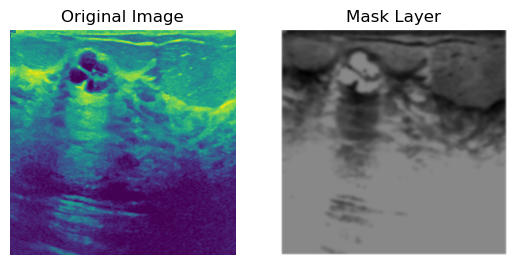

In [14]:
image_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (135).png"
image = Image.open(image_path)
gray_pil_image = image.convert("L")
preprocess = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()])

tensor_image = preprocess(gray_pil_image)
image = tensor_image.unsqueeze(0)
image = image.to(device)

torch.manual_seed(42)
img_shape = image.shape
p_img, p_image_shape = model_1(image)
numpy_img1 = p_img[0][0].detach().cpu().numpy()
fig,axs = plt.subplots(1, 2)
print('Shape of Original image', img_shape)
print('Shape of Processed image', p_image_shape)
axs[0].imshow(image.cpu().view(image.shape[2], image.shape[3], image.shape[1]))
axs[0].set_title('Original Image')
axs[0].axis(False)
axs[1].imshow(numpy_img1, cmap='gray')
axs[1].set_title('Mask Layer')
axs[1].axis(False);

In [15]:
torch.save(model_1.state_dict(), 'U-Net_model_weights.pth')
torch.save(model_1,'U-Net_model.pth')